In [6]:
from vif.utils.detection_utils import get_segmentation_masks
from vif.utils.image_utils import plot_segmentation_masks
from vif.utils.renderer.tex_renderer import TexRenderer
from PIL import Image
from google import genai
from google.genai import types as genTypes
import os
# APIs used
gclient = genai.Client(
    api_key=os.environ.get("GOOGLE_API_KEY"),
    http_options=genTypes.HttpOptions(api_version="v1alpha"),
)

# Models used
temperature=0.3,
visual_model="gemini-2.5-flash"

### With code rendering

In [8]:
renderer = TexRenderer()

code = open("notebooks/protos/code/centered_circles.tex").read()

stcg = renderer.from_string_to_image(code)
stcg.save("tests/resources/seg/centered_circles.png")

2025-09-17 14:42:57.304 | DEBUG    | vif.utils.renderer.tex_renderer:from_string_to_image:45 - latex renderer writing to /home/creux/.cache/varbench/157550f2-b5c8-4977-a8c0-6c00fd84c81c.tex
2025-09-17 14:42:57.602 | DEBUG    | vif.utils.renderer.tex_renderer:from_string_to_image:78 - converting /home/creux/.cache/varbench/157550f2-b5c8-4977-a8c0-6c00fd84c81c.tex to png


2025-09-16 16:43:18.134 | INFO     | vif.utils.detection_utils:get_segmentation_masks:156 - Getting masks for features : circle,square,triangle
2025-09-16 16:43:24.202 | INFO     | vif.utils.detection_utils:get_segmentation_masks:190 - LLM segmentation response: ```json
[
  {"box_2d": [33, 349, 404, 702], "mask": "", "label": "square"},
  {"box_2d": [453, 613, 825, 966], "mask": "<start_of_mask><seg_60><seg_59><seg_58><seg_111><seg_44><seg_27><seg_27><seg_100><seg_50><seg_27><seg_27><seg_3><seg_91><seg_1><seg_17>", "label": "circle"},
  {"box_2d": [544, 33, 963, 489], "mask": "", "label": "triangle"}
]
```
2025-09-16 16:43:24.203 | WARNING  | vif.utils.detection_utils:log_and_append_token_data:265 - [{'box_2d': [33, 349, 404, 702], 'mask': '', 'label': 'square'}, {'box_2d': [453, 613, 825, 966], 'mask': '<start_of_mask><seg_60><seg_59><seg_58><seg_111><seg_44><seg_27><seg_27><seg_100><seg_50><seg_27><seg_27><seg_3><seg_91><seg_1><seg_17>', 'label': 'circle'}, {'box_2d': [544, 33, 963, 
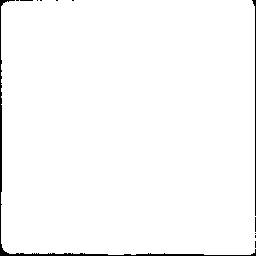
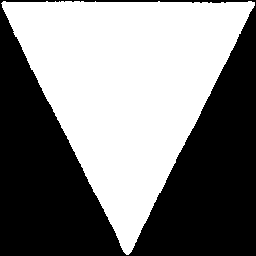
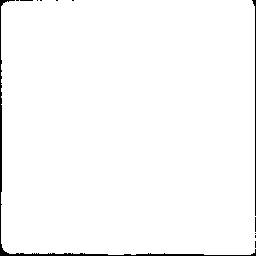
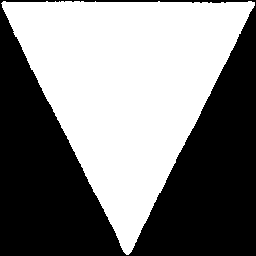

Invalid mask


2025-09-16 16:43:27.833 | INFO     | vif.utils.detection_utils:get_segmentation_masks:190 - LLM segmentation response: ```json
[
  {"box_2d": [32, 349, 405, 702], "mask": "", "label": "square"},
  {"box_2d": [453, 613, 826, 966], "mask": "", "label": "circle"},
  {"box_2d": [544, 33, 963, 489], "mask": "", "label": "triangle"}
]
```
2025-09-16 16:43:27.835 | WARNING  | vif.utils.detection_utils:log_and_append_token_data:265 - Segmentation worked.
2025-09-16 16:43:27.835 | INFO     | vif.utils.caching:checkForCached:42 - new cache
2025-09-16 16:43:27.836 | INFO     | vif.utils.caching:checkForCached:43 - {'980f5144eab9fd9198b1a7f4d3b2f3478c6c96af': ([SegmentationMask(y0=13, x0=155, y1=170, x1=313, mask=array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False
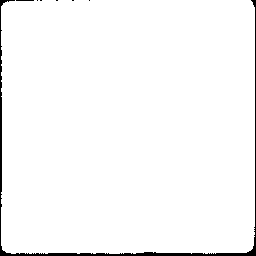
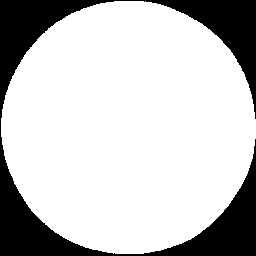
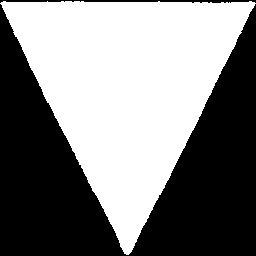
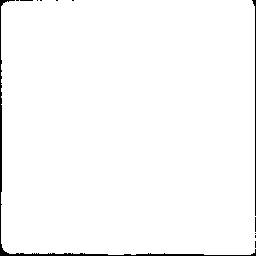
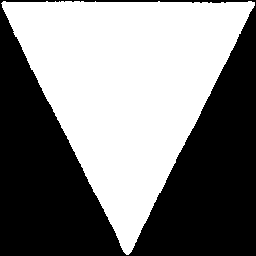

In [3]:
d = get_segmentation_masks(stcg,gclient,["circle","square","triangle"],visual_model)[0]

In [4]:
import pickle

with open("tests/resources/seg/rgbp_stc.pickle","wb") as square_blurple_file:
    pickle.dump(d,square_blurple_file)

### With image path directly

In [14]:
colnodes = Image.open("tests/resources/seg/centered_circles_neg.png")

2025-09-17 14:44:17.852 | INFO     | vif.utils.detection_utils:get_segmentation_masks:156 - Getting masks for features : brown circle,red circle
2025-09-17 14:44:24.611 | INFO     | vif.utils.detection_utils:get_segmentation_masks:190 - LLM segmentation response: ```json
[
  {"box_2d": [346, 496, 650, 800], "mask": "", "label": "red circle"},
  {"box_2d": [50, 53, 946, 946], "mask": "", "label": "brown circle"}
]
```
2025-09-17 14:44:24.612 | WARNING  | vif.utils.detection_utils:log_and_append_token_data:265 - Segmentation worked.
2025-09-17 14:44:24.613 | INFO     | vif.utils.caching:checkForCached:42 - new cache
2025-09-17 14:44:24.614 | INFO     | vif.utils.caching:checkForCached:43 - {'3de99c34918c535a5ea576c4f11cb53fd6d04e0e': ([SegmentationMask(y0=92, x0=92, y1=171, x1=171, mask=array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, Fa
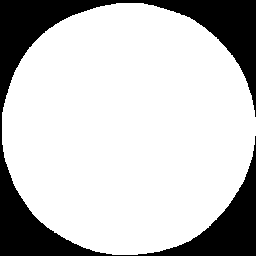
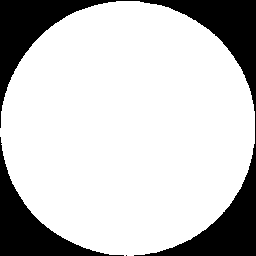

In [15]:
colnode_seg = get_segmentation_masks(
    colnodes,
    gclient,
    [
        "brown circle",
        "red circle",
    ],
    visual_model,
)[0]

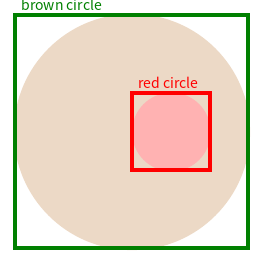

In [16]:
plot_segmentation_masks(colnodes,colnode_seg)

In [17]:
[(colnode_se.label,colnode_se.box_prob) for colnode_se in colnode_seg]

[('red circle', 0.651469649830981), ('brown circle', 0.8229688146461515)]

In [18]:
import numpy as np
im_ar = [Image.fromarray(colnode_se.mask) for colnode_se in colnode_seg]
im_ar_mi = [Image.fromarray(np.flip(colnode_se.mask,0)) for colnode_se in colnode_seg]




In [18]:
import pickle

with open("tests/resources/seg/centered_circles_neg.pickle", "wb") as pseg:
    pickle.dump(colnode_seg,pseg) 

In [3]:
import pickle
with open("tests/resources/seg/dog_eyes_face.pickle", "rb") as pseg:
    s = pickle.load(pseg)

In [12]:
for im,im_mi in zip(im_ar,im_ar_mi):
    display(im)
    display(im_mi)

NameError: name 'im_ar' is not defined

In [ ]:
print(np.logical_and(s[1].mask, s[1].mask).sum())
print(s[1].mask.sum())


360
360


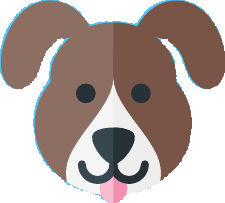

In [5]:
from vif.utils.image_utils import apply_mask, crop_image_with_box


cropped = apply_mask(colnodes,s[2].mask)
boxed = Image.fromarray(crop_image_with_box(cropped,(s[2].x0,s[2].x1,s[2].y0,s[2].y1)))
boxed